In [2]:
# ===== 0) 환경 설정 및 Import =====
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

print("환경 설정 완료")

환경 설정 완료


In [4]:
# ===== 1) 설정 =====
DATA_PATH = "/home/wza/QR_Phishing/phishing/phishing_data_tflite_ready.csv"
TARGET_COL = "status"
RANDOM_SEED = 42

# 시드 설정
np.random.seed(RANDOM_SEED)

print(f"설정 완료: RANDOM_SEED={RANDOM_SEED}")

설정 완료: RANDOM_SEED=42


In [5]:
# ===== 2) 데이터 로드 및 전처리 =====
df = pd.read_csv(DATA_PATH)
print(f"데이터 shape: {df.shape}")
print(f"\n컬럼 목록:\n{df.columns.tolist()}")
print(f"\n처음 5행:\n{df.head()}")

# 타겟 변수 확인
print(f"\n타겟 변수 ({TARGET_COL}) 분포:")
print(df[TARGET_COL].value_counts())

데이터 shape: (11481, 72)

컬럼 목록:
['length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma', 'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url', 'ratio_digits_host', 'punycode', 'port', 'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains', 'prefix_suffix', 'random_domain', 'shortening_service', 'path_extension', 'nb_redirection', 'nb_external_redirection', 'length_words_raw', 'char_repeat', 'shortest_words_raw', 'shortest_word_host', 'shortest_word_path', 'longest_words_raw', 'longest_word_host', 'longest_word_path', 'avg_words_raw', 'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand', 'brand_in_subdomain', 'brand_in_path', 'suspecious_tld', 'statistical_report', 'nb_extCSS', 'ratio_intRedirection', 'ratio_extRedirection', 'ratio_intErrors', 

In [6]:
# ===== 3) 피처 및 레이블 분리 (50:50 균형 분할) =====
# 원본 데이터 보존을 위해 복사본 사용
df_work = df.copy()

# 'id' 컬럼이 있다면 제거
if 'id' in df_work.columns:
    df_work = df_work.drop(columns=['id'])

# 타겟 변수 그대로 사용
# status: 0 = 정상, 1 = 피싱
print(f"피처 개수: {len(df_work.columns) - 1}")
print(f"전체 데이터 shape: {df_work.shape}")
print(f"\n원본 레이블 분포:")
print(f"  - 정상(0): {(df_work[TARGET_COL]==0).sum()}")
print(f"  - 피싱(1): {(df_work[TARGET_COL]==1).sum()}")

# ===== 50:50 균형 분할 함수 =====
def split_class(class_df, train_ratio=0.6, val_ratio=0.2, seed=42):
    """클래스별로 train/val/test 분할"""
    # 여러 번 셔플해서 패턴 편향 방지
    shuffled = class_df.sample(frac=1, random_state=seed)
    shuffled = shuffled.sample(frac=1, random_state=seed+1)
    shuffled = shuffled.sample(frac=1, random_state=seed+2)
    
    n = len(shuffled)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    return (shuffled.iloc[:train_end], 
            shuffled.iloc[train_end:val_end], 
            shuffled.iloc[val_end:])

# 클래스별로 분리
df_legit = df_work[df_work[TARGET_COL] == 0]  # 정상
df_phish = df_work[df_work[TARGET_COL] == 1]  # 피싱

# 각 클래스별로 60/20/20 분할
legit_train, legit_val, legit_test = split_class(df_legit, seed=RANDOM_SEED)
phish_train, phish_val, phish_test = split_class(df_phish, seed=RANDOM_SEED)

# 합치기 (각 세트에서 50:50 비율 유지)
train_df = pd.concat([legit_train, phish_train]).sample(frac=1, random_state=RANDOM_SEED)
val_df = pd.concat([legit_val, phish_val]).sample(frac=1, random_state=RANDOM_SEED)
test_df = pd.concat([legit_test, phish_test]).sample(frac=1, random_state=RANDOM_SEED)

# 피처와 레이블 분리
X_train = train_df.drop(columns=[TARGET_COL]).values.astype(np.float32)
y_train = train_df[TARGET_COL].values.astype(np.float32)

X_val = val_df.drop(columns=[TARGET_COL]).values.astype(np.float32)
y_val = val_df[TARGET_COL].values.astype(np.float32)

X_test = test_df.drop(columns=[TARGET_COL]).values.astype(np.float32)
y_test = test_df[TARGET_COL].values.astype(np.float32)

# 결과 출력
print(f"\n===== 50:50 균형 분할 결과 =====")
print(f"Train: {X_train.shape} - 정상:{(y_train==0).sum()}, 피싱:{(y_train==1).sum()}")
print(f"Val:   {X_val.shape} - 정상:{(y_val==0).sum()}, 피싱:{(y_val==1).sum()}")
print(f"Test:  {X_test.shape} - 정상:{(y_test==0).sum()}, 피싱:{(y_test==1).sum()}")

# 비율 확인
print(f"\n===== 각 세트의 피싱 비율 =====")
print(f"Train 피싱 비율: {y_train.mean()*100:.1f}%")
print(f"Val 피싱 비율:   {y_val.mean()*100:.1f}%")
print(f"Test 피싱 비율:  {y_test.mean()*100:.1f}%")

피처 개수: 71
전체 데이터 shape: (11481, 72)

원본 레이블 분포:
  - 정상(0): 5740
  - 피싱(1): 5741

===== 50:50 균형 분할 결과 =====
Train: (6888, 71) - 정상:3444, 피싱:3444
Val:   (2296, 71) - 정상:1148, 피싱:1148
Test:  (2297, 71) - 정상:1148, 피싱:1149

===== 각 세트의 피싱 비율 =====
Train 피싱 비율: 50.0%
Val 피싱 비율:   50.0%
Test 피싱 비율:  50.0%


In [7]:
# ===== 4) 데이터 전처리 (RobustScaler - embedding_model과 동일) =====
from sklearn.preprocessing import RobustScaler

# RobustScaler를 적용할 피처 목록 (이상치가 많은 피처들)
robust_cols = [
    'length_url',
    'length_hostname',
    'nb_dots',
    'nb_hyphens',
    'nb_and',
    'nb_eq',
    'nb_underscore',
    'nb_percent',
    'nb_slash',
    'nb_colon',
    'nb_semicolumn',
    'nb_space',
    'nb_com',
    'ratio_digits_url',
    'ratio_digits_host',
    'nb_redirection',
    'length_words_raw',
    'char_repeat',
    'shortest_words_raw',
    'shortest_word_host',
    'shortest_word_path',
    'longest_words_raw',
    'longest_word_host',
    'longest_word_path',
    'avg_words_raw',
    'avg_word_host',
    'avg_word_path',
    'phish_hints',
    'nb_extCSS',
    'ratio_extRedirection',
    'ratio_extErrors',
]

# 피처 인덱스 매핑
feature_names = [col for col in df_work.columns if col != TARGET_COL]
robust_indices = [feature_names.index(col) for col in robust_cols if col in feature_names]
raw_indices = [i for i in range(len(feature_names)) if i not in robust_indices]

print(f"RobustScaler 적용 피처: {len(robust_indices)}개")
print(f"정규화 없음 (원본 그대로): {len(raw_indices)}개")

# RobustScaler 생성
robust_scaler = RobustScaler()

# 스케일링 수행
X_train_scaled = X_train.copy().astype(np.float32)
X_val_scaled = X_val.copy().astype(np.float32)
X_test_scaled = X_test.copy().astype(np.float32)

# RobustScaler 적용만 (중앙값 기반 - 이상치 영향 적음)
X_train_scaled[:, robust_indices] = robust_scaler.fit_transform(X_train[:, robust_indices]).astype(np.float32)
X_val_scaled[:, robust_indices] = robust_scaler.transform(X_val[:, robust_indices]).astype(np.float32)
X_test_scaled[:, robust_indices] = robust_scaler.transform(X_test[:, robust_indices]).astype(np.float32)

# raw_indices는 그대로 두기 (정규화 안 함)

print("\n데이터 전처리 완료 (RobustScaler - embedding_model과 동일)")
print(f"Train 피처 범위: min={X_train_scaled.min():.2f}, max={X_train_scaled.max():.2f}")
print(f"Train 피처 평균: {X_train_scaled.mean():.4f}, 표준편차: {X_train_scaled.std():.4f}")
print(f"피처 개수: {X_train_scaled.shape[1]}개")

RobustScaler 적용 피처: 31개
정규화 없음 (원본 그대로): 40개

데이터 전처리 완료 (RobustScaler - embedding_model과 동일)
Train 피처 범위: min=-2.00, max=124.00
Train 피처 평균: 0.2332, 표준편차: 1.0991
피처 개수: 71개


In [8]:
# ===== 5) XGBoost 모델 학습 =====
print("XGBoost 모델 학습 시작...")

xgb_model = XGBClassifier(
    max_depth=5,
    n_estimators=100,
    learning_rate=0.1,
    random_state=RANDOM_SEED,
    eval_metric='logloss',
    early_stopping_rounds=10,
    verbosity=0
)

# 학습 (early stopping 포함)
xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=False
)

print(f"✅ XGBoost 모델 학습 완료!")
print(f"   최종 트리 개수: {xgb_model.n_estimators}")
print(f"   Best iteration: {xgb_model.best_iteration if hasattr(xgb_model, 'best_iteration') else 'N/A'}")

XGBoost 모델 학습 시작...
✅ XGBoost 모델 학습 완료!
   최종 트리 개수: 100
   Best iteration: 99
✅ XGBoost 모델 학습 완료!
   최종 트리 개수: 100
   Best iteration: 99


In [9]:
# ===== 분할 검증 (데이터 손실/중복 확인) =====
print("\n" + "="*60)
print("분할 검증")
print("="*60)

# 1) 데이터 중복/손실 확인
total_samples = len(X_train) + len(X_val) + len(X_test)
print(f"\n1️⃣ 데이터 무결성 확인:")
print(f"   Train + Val + Test = {total_samples}")
print(f"   원본 데이터 = {len(X_train_scaled) + len(X_val_scaled) + len(X_test_scaled)}")
print(f"   ✅ 일치" if total_samples == len(df_work) else f"   ❌ 불일치")

# 2) 비율 확인
print(f"\n2️⃣ 분할 비율 확인 (60:20:20):")
print(f"   Train: {len(X_train)} ({len(X_train)/len(df_work)*100:.1f}%)")
print(f"   Val:   {len(X_val)} ({len(X_val)/len(df_work)*100:.1f}%)")
print(f"   Test:  {len(X_test)} ({len(X_test)/len(df_work)*100:.1f}%)")

# 3) 클래스 균형 확인
print(f"\n3️⃣ 클래스 균형 확인 (각 세트 50:50):")
for name, y in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    legit_count = (y==0).sum()
    phish_count = (y==1).sum()
    legit_ratio = legit_count / len(y) * 100
    phish_ratio = phish_count / len(y) * 100
    print(f"   {name}: 정상 {legit_count}({legit_ratio:.1f}%), 피싱 {phish_count}({phish_ratio:.1f}%)")

print("\n" + "="*60)


분할 검증

1️⃣ 데이터 무결성 확인:
   Train + Val + Test = 11481
   원본 데이터 = 11481
   ✅ 일치

2️⃣ 분할 비율 확인 (60:20:20):
   Train: 6888 (60.0%)
   Val:   2296 (20.0%)
   Test:  2297 (20.0%)

3️⃣ 클래스 균형 확인 (각 세트 50:50):
   Train: 정상 3444(50.0%), 피싱 3444(50.0%)
   Val: 정상 1148(50.0%), 피싱 1148(50.0%)
   Test: 정상 1148(50.0%), 피싱 1149(50.0%)



In [10]:
# ===== 6) 모델 평가 =====
print("="*60)
print("모델 평가 (Test Set)")
print("="*60)

# 예측
y_pred = xgb_model.predict(X_test_scaled)
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# 메트릭 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print(f"\n📊 성능 메트릭:")
print(f"  - Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  - Precision: {precision:.4f}")
print(f"  - Recall:    {recall:.4f}")
print(f"  - F1 Score:  {f1:.4f}")
print(f"  - AUC-ROC:   {auc_roc:.4f}")

print(f"\n📋 분류 리포트:")
print(classification_report(y_test, y_pred, target_names=['Phishing', 'Legitimate']))

모델 평가 (Test Set)

📊 성능 메트릭:
  - Accuracy:  0.9364 (93.64%)
  - Precision: 0.9334
  - Recall:    0.9399
  - F1 Score:  0.9367
  - AUC-ROC:   0.9814

📋 분류 리포트:
              precision    recall  f1-score   support

    Phishing       0.94      0.93      0.94      1148
  Legitimate       0.93      0.94      0.94      1149

    accuracy                           0.94      2297
   macro avg       0.94      0.94      0.94      2297
weighted avg       0.94      0.94      0.94      2297



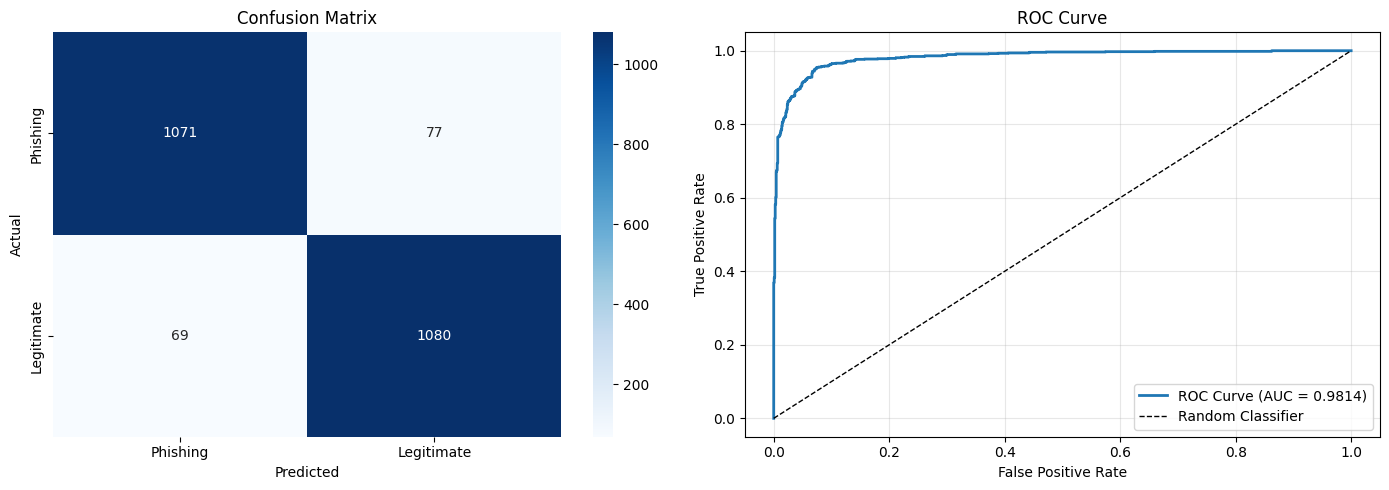

In [11]:
# ===== 7) 시각화 (Confusion Matrix, ROC Curve) =====
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Phishing', 'Legitimate'],
            yticklabels=['Phishing', 'Legitimate'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_roc:.4f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ===== 8) 최종 요약 =====
print("\n" + "="*60)
print("모델 학습 및 평가 완료")
print("="*60)

print(f"\n📊 모델 성능:")
print(f"  - Accuracy:  {accuracy:.4f}")
print(f"  - Precision: {precision:.4f}")
print(f"  - Recall:    {recall:.4f}")
print(f"  - F1 Score:  {f1:.4f}")
print(f"  - AUC-ROC:   {auc_roc:.4f}")

print(f"\n📈 데이터셋 정보:")
print(f"  - 전체 샘플: {len(df)}")
print(f"  - 피처: {len(feature_names)}개")
print(f"  - Train: {len(X_train)} (정상 {(y_train==0).sum()}, 피싱 {(y_train==1).sum()})")
print(f"  - Val: {len(X_val)} (정상 {(y_val==0).sum()}, 피싱 {(y_val==1).sum()})")
print(f"  - Test: {len(X_test)} (정상 {(y_test==0).sum()}, 피싱 {(y_test==1).sum()})")

print("\n✅ XGBoost 모델 완료!")